In [2]:
import tensorflow as tf

In [3]:
import keras

Using TensorFlow backend.


In [4]:
import cleverhans

In [5]:
from cleverhans.attacks import FastGradientMethod

In [6]:
from keras.datasets import mnist

In [7]:
from cleverhans.utils_tf import model_train, model_eval

In [8]:
from cleverhans.utils_keras import KerasModelWrapper

In [9]:
from cleverhans.utils import AccuracyReport

In [10]:
import os

In [11]:
import matplotlib.pyplot as plt

In [12]:
from keras.models import Sequential

In [13]:
from keras.layers import Dense, Dropout,Flatten

In [14]:
from keras.models import Model

In [15]:
from keras.models import model_from_json

In [16]:
from keras.layers import Conv2D, MaxPooling2D, Activation

In [17]:
import tensorflow as tf

In [18]:
from keras import backend as K

In [19]:
import numpy as np

In [20]:
from keras import layers
from keras import models

In [21]:
session= tf.Session()
keras.backend.set_session(session)

In [22]:
(x_train,y_train), (x_test,y_test)=mnist.load_data()


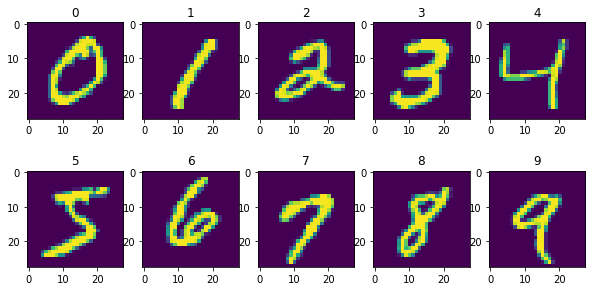

In [23]:
n_classes=10
inde= np.array([y_train==i for i in range(n_classes)])
f,ax = plt.subplots(2,5, figsize=(10,5))
ax=ax.flatten()
for i in range(n_classes):
    ax[i].imshow(x_train[np.argmax(inde[i])].reshape(28,28))
    ax[i].set_title(str(i))
plt.show()

In [24]:
#Build the network using keras
model= models.Sequential()
model.add(layers.Dense(512,activation='relu', input_shape=(28*28,)))
model.add(layers.Dense(10, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy, 
                  optimizer='rmsprop', 
                  metrics=['accuracy'])

In [25]:
#preprocess the images - normalizze the images so pixel values are between 0 and 1 instead of 0 and 255
x_train_p=x_train.reshape((60000,28*28))
x_train_p=x_train_p.astype('float32')/255
    
x_test_p=x_test.reshape((10000, 28*28))
    
x_test_p=x_test_p.astype('float32')/255

In [26]:
# convert the label to one hot vectors
from keras.utils import to_categorical
y_train_p= keras.utils.to_categorical(y_train, n_classes)
y_test_p= keras.utils.to_categorical(y_test, n_classes)

In [27]:
model.fit(x_train_p, y_train_p, 
              batch_size=128, 
              epochs=5, shuffle=True, 
              )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5




60000/60000 [==============================] - 3s 54us/step - loss: 0.2578 - acc: 0.9251
Epoch 2/5
60000/60000 [==============================] - 2s 32us/step - loss: 0.1041 - acc: 0.9688
Epoch 3/5
60000/60000 [==============================] - 2s 33us/step - loss: 0.0697 - acc: 0.9792
Epoch 4/5
60000/60000 [==============================] - 2s 33us/step - loss: 0.0506 - acc: 0.9847
Epoch 5/5
60000/60000 [==============================] - 2s 32us/step - loss: 0.0374 - acc: 0.9887


In [28]:
#model accuracy when trained on legitimate input
score, acc= model.evaluate(x_test_p, y_test_p, batch_size=128)
print("Test Accuracy: %.5f" % acc)

10000/10000 [==============================] - 0s 19us/step
Test Accuracy: 0.97910


In [29]:
model.save('cnn_mnist')

# FGSM Adversarial Attacks

In [30]:
#use cleverhans library to generate adversarial examples
wrap= KerasModelWrapper(model)

In [31]:
x=tf.placeholder(tf.float32, shape=(None,784))
y=tf.placeholder(tf.float32, shape=(None,10))

In [32]:
fgsm= FastGradientMethod(wrap, sess=session)
fgsm

In [33]:
#FGSM- Gast Gradient Sign method - non targeted attack
fgsm_params= {'eps':0.08, 'clip_min':0.,'clip_max':1.}
adv_x = fgsm.generate(x, **fgsm_params)
adv_x=tf.stop_gradient(adv_x)
preds_adv=model(adv_x)

Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
dim is deprecated, use axis instead


In [34]:
fetches=[preds_adv]
fetches.append(adv_x)
outputs=session.run(fetches=fetches, feed_dict={x:x_test_p})
preds_adv = outputs[0]
adv_examples=outputs[1]

In [35]:
adv_predicted=preds_adv.argmax(1)
adv_accuracy= np.mean(adv_predicted == y_test)
print("Adversaral accuracy: %.5f" % adv_accuracy)

Adversaral accuracy: 0.32020


In [36]:
print(adv_predicted[1500])

7


In [37]:
print(y_test[1500])

7


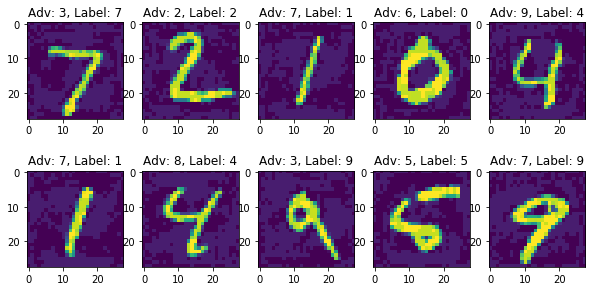

In [38]:
n_classes=10
f,ax = plt.subplots(2,5, figsize=(10,5))
ax=ax.flatten()
for i in range(n_classes):
    ax[i].imshow(adv_examples[i].reshape(28,28))
    ax[i].set_title("Adv: %d, Label: %d" % (adv_predicted[i], y_test[i]))
plt.show()

# JSMA - Jacobian based saliency map attack

In [39]:
## targeted attack

In [41]:
 x1 = tf.placeholder(tf.float32, shape=(None, 784))
 y1 = tf.placeholder(tf.float32, shape=(None, 10))


In [42]:
#create a saliency map - a grid to keep the feature vectors of input and the jacobian 
#generate perturbations. 
#Find jacobian and choose the adversarial examples which are moving in direction of y
#generate targeted attack - other than current y-label
#store the results

In [43]:
#initialize
results = np.zeros((10,10000))
perturbations = np.zeros((10,10000))
grid_shape =(10,10,28,28,1)
grid_data =(np.zeros(grid_shape))

In [44]:
from cleverhans.attacks import SaliencyMapMethod

In [45]:
jsma= SaliencyMapMethod(wrap,sess=session)

In [46]:
jsma_params = {'theta': 1.,
              'gamma':0.1,
              'clip_min': 0.,
              'clip_max':1.,
              'y_target':None}

In [47]:
from cleverhans.utils import other_classes, grid_visual
#for targeted attack

In [52]:
for index in range(int(len(x_test)/100)):
    sample= x_test_p[index:index+1]
    current=y_test[index]
    target_classes=other_classes(10, current)
    grid_data[current, current, :, :, :]= np.reshape(sample, (28,28,1))
    
    for target in target_classes:
        one_hot_target= np.zeros((1,10))
        one_hot_target[0,target]=1
        jsma_params['y_target']=one_hot_target
        adv_x= jsma.generate_np(sample, **jsma_params)
        grid_data[target, current, :, :, :]= np.reshape(adv_x, (28,28,1))
    
    if index % 10 == 0:
        print(index)
        print(sample.shape)
        print(one_hot_target)
        print(adv_x.shape)

0
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)
10
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)
20
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
(1, 784)
30
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)
40
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)
50
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)
60
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)
70
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)
80
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)
90
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)


[INFO 2019-12-03 10:58:31,937 cleverhans] Constructing new graph for attack SaliencyMapMethod


/home/ubuntu/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/cleverhans/attacks_tf.py:356: UserWarning: Downcasting labels---this should be harmless unless they are smoothed
  warnings.warn("Downcasting labels---this should be harmless unless"


In [53]:
print(y_test[80])

7


In [55]:
print(y_test[90])

3
